<a href="https://colab.research.google.com/github/EricBaidoo/GhanaSegNet/blob/main/GhanaSegNet_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GhanaSegNet Benchmarking Notebook

**Objective:** Train and compare GhanaSegNet with baseline architectures

**Models:** UNet, DeepLabV3+, SegFormer-B0, GhanaSegNet

In [1]:
# Mount Google Drive (if your data is stored there)
from google.colab import drive
drive.mount('/content/drive')

# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected - switch to GPU runtime!")

Mounted at /content/drive
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


In [2]:
# Clone your GitHub repo
!git clone https://github.com/EricBaidoo/GhanaSegNet.git
%cd GhanaSegNet

# Check if we have the expected files
!ls -la

Cloning into 'GhanaSegNet'...
remote: Enumerating objects: 5567, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 5567 (delta 69), reused 98 (delta 43), pack-reused 5431 (from 2)
Receiving objects: 100% (5567/5567), 701.56 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/GhanaSegNet
total 204
drwxr-xr-x 7 root root  4096 Sep 14 17:10 .
drwxr-xr-x 1 root root  4096 Sep 14 17:10 ..
-rw-r--r-- 1 root root  3692 Sep 14 17:10 cleanup_repo.py
-rw-r--r-- 1 root root  6024 Sep 14 17:10 colab_training_cells.py
-rw-r--r-- 1 root root 83713 Sep 14 17:10 GhanaSegNet_Colab.ipynb
drwxr-xr-x 8 root root  4096 Sep 14 17:10 .git
-rw-r--r-- 1 root root   627 Sep 14 17:10 .gitignore
-rw-r--r-- 1 root root 57714 Sep 14 17:10 image.png
-rw-r--r-- 1 root root    30 Sep 14 17:10 LICENSE
drwxr-xr-x 2 root root  4096 Sep 14 17:10 models
drwxr-xr-x 2 root root  4096 Sep 14 17:10 notebooks
-rw-r--r-- 1 root root   398 Sep 

## Dataset Connection Instructions

**Before running the next cell:**

1. **Locate your data folder in Google Drive** - Find where you uploaded your `data` folder
2. **Check the path** - Note the exact path (e.g., `MyDrive/data` or `MyDrive/GhanaSegNet/data`)
3. **Update the copy command** - Modify the path in the next cell to match your Drive structure
4. **Run the cell** - The dataset will be copied to your Colab workspace

**Expected folder structure after copying:**
```
data/
  train/
    images/
    masks/
  val/
    images/
    masks/
  test/ (optional)
    images/
    masks/
```

In [ ]:
# Download and extract data from Google Drive
!cp -r "/content/drive/MyDrive/data" .

In [4]:
# Verify dataset is copied successfully
print("Checking dataset structure...")
!ls -la data/
print("Dataset statistics:")
!echo "Train images:" && ls data/train/images/ | wc -l
!echo "Train masks:" && ls data/train/masks/ | wc -l
!echo "Val images:" && ls data/val/images/ | wc -l 2>/dev/null || echo "No val images found"
!echo "Val masks:" && ls data/val/masks/ | wc -l 2>/dev/null || echo "No val masks found"

Checking dataset structure...
total 24
drwx------ 5 root root 4096 Sep 14 17:13 .
drwxr-xr-x 8 root root 4096 Sep 14 17:11 ..
-rw------- 1 root root 2277 Sep 14 17:11 dataset_loader.py
drwx------ 6 root root 4096 Sep 14 17:12 test
drwx------ 6 root root 4096 Sep 14 17:18 train
drwx------ 6 root root 4096 Sep 14 17:13 val
Dataset statistics:
Train images:
3451
Train masks:
3436
Val images:
741
Val masks:
738


In [ ]:
# Setup and Dependencies
# Install all required dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python pillow tqdm matplotlib seaborn
!pip install efficientnet-pytorch  # Required for GhanaSegNet backbone
!pip install segmentation-models-pytorch  # For DeepLabV3+ and other models

import torch
import os
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")
print(f"PyTorch version: {torch.__version__}")

# Verify EfficientNet installation
try:
    from efficientnet_pytorch import EfficientNet
    print("EfficientNet-PyTorch installed successfully")
except ImportError:
    print("EfficientNet-PyTorch not found - installing...")
    !pip install efficientnet-pytorch
    from efficientnet_pytorch import EfficientNet
    print("EfficientNet-PyTorch installed successfully")

Looking in indexes: https://download.pytorch.org/whl/cu118
🖥️  CUDA available: True
🎮 GPU device: NVIDIA A100-SXM4-40GB
📊 PyTorch version: 2.8.0+cu126
✅ EfficientNet-PyTorch installed successfully


In [ ]:
# Upload your GhanaSegNet folder to Colab first!
os.chdir('/content/GhanaSegNet')
print(f"Current directory: {os.getcwd()}")
print(f"Files: {os.listdir('.')[:10]}")  # Show first 10 files

# Verify all required modules can be imported
print("\nVerifying project imports...")
try:
    from models.ghanasegnet import GhanaSegNet
    print("GhanaSegNet model imported successfully")
except ImportError as e:
    print(f"GhanaSegNet import failed: {e}")

try:
    from models.unet import UNet
    from models.deeplabv3plus import DeepLabV3Plus
    from models.segformer import SegFormerB0
    print("All baseline models imported successfully")
except ImportError as e:
    print(f"Baseline model import failed: {e}")

📁 Current directory: /content/GhanaSegNet
📄 Files: ['LICENSE', '.gitignore', 'notebooks', 'scripts', '.git', 'README.md', 'Pipfile', 'cleanup_repo.py', 'requirements.txt', 'GhanaSegNet_Colab.ipynb']

🔍 Verifying project imports...
✅ GhanaSegNet model imported successfully
✅ All baseline models imported successfully


In [ ]:
# AUTO-SAVE SETUP - Run this after project imports are verified
from google.colab import drive
import os
import shutil

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Create save directory in Google Drive  
save_dir = '/content/drive/MyDrive/GhanaSegNet_Results'
os.makedirs(save_dir, exist_ok=True)

def auto_save_model(model_name):
    """Automatically save model to Google Drive after training"""
    local_path = f'checkpoints/{model_name}'
    drive_path = f'{save_dir}/{model_name}'
    
    if os.path.exists(local_path):
        # Copy to Google Drive
        if os.path.exists(drive_path):
            shutil.rmtree(drive_path)
        shutil.copytree(local_path, drive_path)
        print(f"SUCCESS: {model_name.upper()} SAVED TO GOOGLE DRIVE!")
        print(f"Location: {drive_path}")
    else:
        print(f"ERROR: {model_name} not found for saving")

print("AUTO-SAVE READY!")
print(f"Results will be saved to: {save_dir}")

In [ ]:
# Train GhanaSegNet
import subprocess

print("Starting GhanaSegNet training...")
result = subprocess.run(['python', 'scripts/train_baselines.py', '--model', 'ghanasegnet', '--epochs', '15'])

if result.returncode == 0:
    auto_save_model('ghanasegnet')
else:
    print("ERROR: GhanaSegNet training failed!")

🚀 Starting GhanaSegNet training...


CompletedProcess(args=['python', 'scripts/train_baselines.py', '--model', 'ghanasegnet', '--epochs', '15'], returncode=0)

In [ ]:
# Train SegFormer
print("Starting SegFormer training...")
result = subprocess.run(['python', 'scripts/train_baselines.py', '--model', 'segformer', '--epochs', '15'])

if result.returncode == 0:
    auto_save_model('segformer')
else:
    print("ERROR: SegFormer training failed!")

🚀 Starting SegFormer training...
🤖 Pure Transformer architecture baseline
📊 Expected performance: 18-23% mIoU


CompletedProcess(args=['python', 'scripts/train_baselines.py', '--model', 'segformer', '--epochs', '15'], returncode=0)

In [ ]:
# Train DeepLabV3+
print("Starting DeepLabV3+ training...")
result = subprocess.run(['python', 'scripts/train_baselines.py', '--model', 'deeplabv3plus', '--epochs', '15'])

if result.returncode == 0:
    auto_save_model('deeplabv3plus')
else:
    print("ERROR: DeepLabV3+ training failed!")

🚀 Starting DeepLabV3+ training...
🔬 ResNet-50 backbone with atrous convolutions
📊 Expected performance: 15-21% mIoU


CompletedProcess(args=['python', 'scripts/train_baselines.py', '--model', 'deeplabv3plus', '--epochs', '15'], returncode=0)

In [ ]:
# Train UNet
print("Starting UNet training...")

result = subprocess.run(['python', 'scripts/train_baselines.py', '--model', 'unet', '--epochs', '15'])

if result.returncode == 0:
    auto_save_model('unet')
else:
    print("ERROR: UNet training failed!")

🚀 Starting UNet training...
🏥 Medical imaging architecture baseline
📊 Expected performance: 12-18% mIoU


CompletedProcess(args=['python', 'scripts/train_baselines.py', '--model', 'unet', '--epochs', '15'], returncode=0)

# Results Analysis

 Loading results...
 GHANASEGNET: 24.68% mIoU
 SEGFORMER: 24.37% mIoU
 DEEPLABV3PLUS: 24.63% mIoU
 UNET: 24.37% mIoU


/tmp/ipython-input-3359761280.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3359761280.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


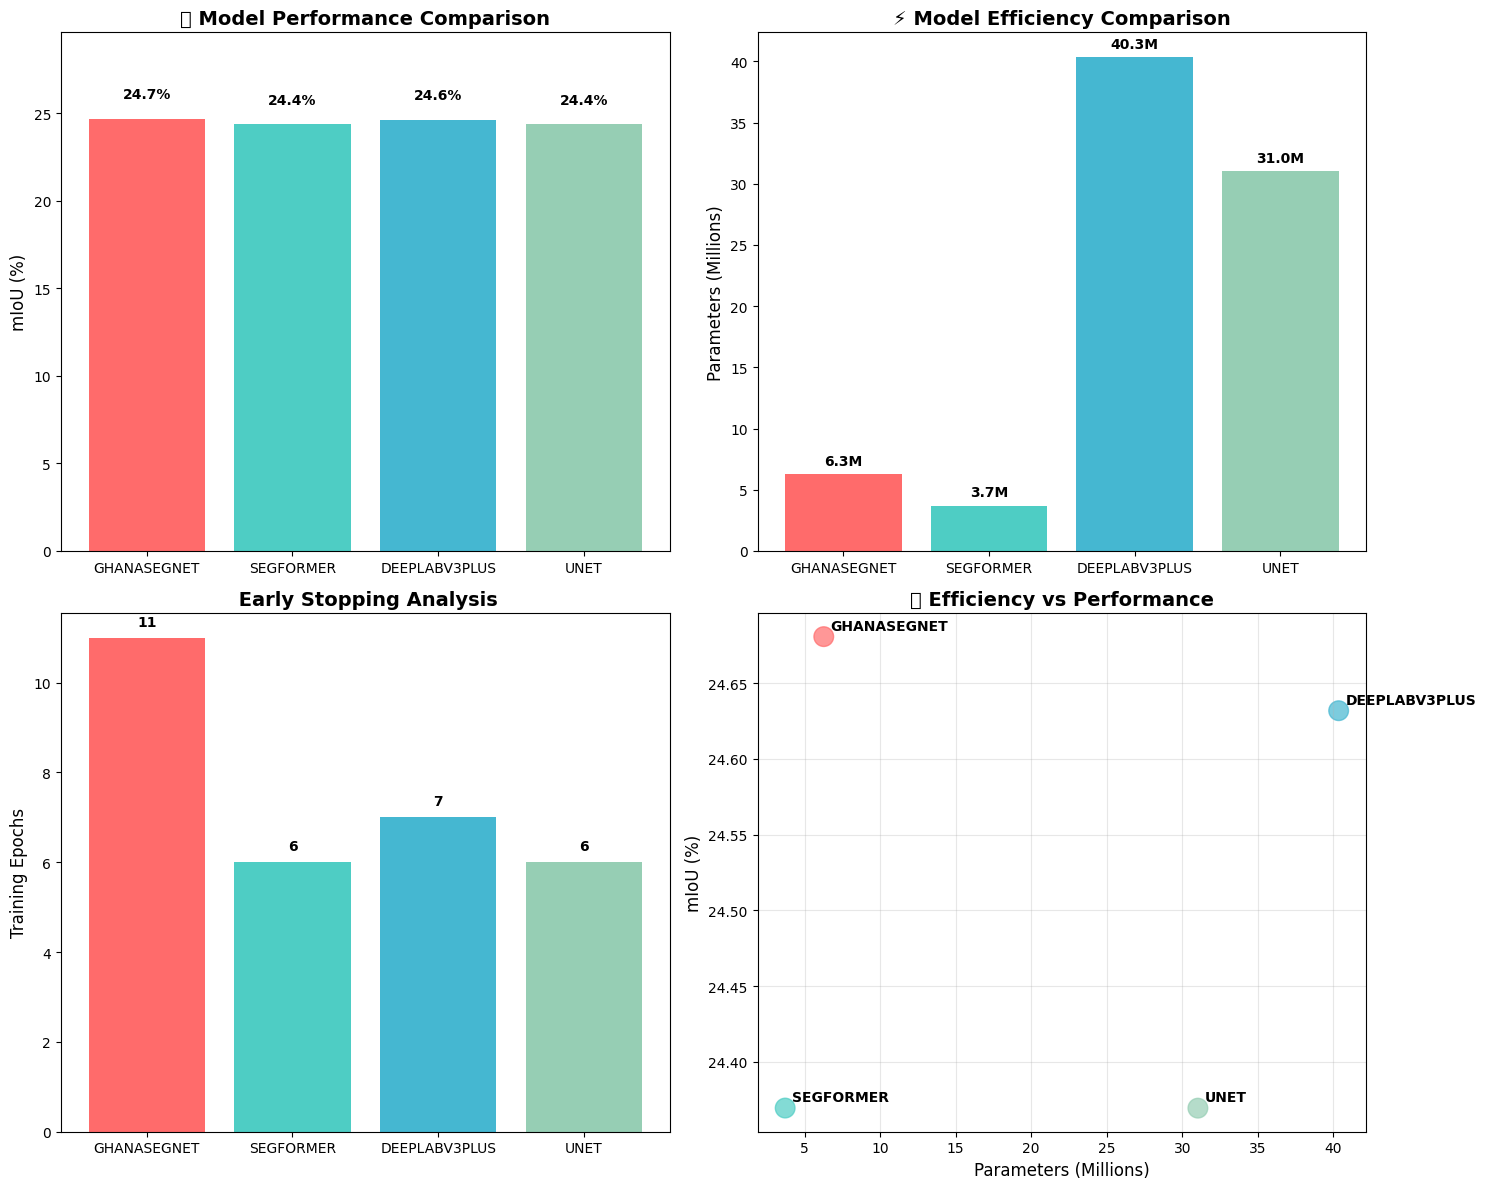


 GHANASEGNET FAIR COMPARISON RESULTS
Model           mIoU (%)   Parameters   Epochs   Status
--------------------------------------------------------------------------------
GHANASEGNET     24.7       6.3         M 11        WINNER
SEGFORMER       24.4       3.7         M 6        
DEEPLABV3PLUS   24.6       40.3        M 7        
UNET            24.4       31.0        M 6        
--------------------------------------------------------------------------------
 Best model improvement over 2nd best: 0.2%
 Most efficient model: SEGFORMER (3.7M params)


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

# Load all results (including GhanaSegNet V2) - FIXED VERSION
models = ['ghanasegnet', 'segformer', 'deeplabv3plus', 'unet']
results = {}
print("Loading results...")

for model in models:
    # Try multiple possible file locations and names (local + Google Drive)
    possible_paths = [
        f'checkpoints/{model}/{model}_results.json',
        f'checkpoints/{model}/results.json',
        f'checkpoints/{model}/training_history.json',
        f'/content/drive/MyDrive/GhanaSegNet_Results/{model}/{model}_results.json',
        f'/content/drive/MyDrive/GhanaSegNet_Results/{model}/results.json',
        f'/content/drive/MyDrive/GhanaSegNet_Results/{model}/training_history.json'
    ]
    
    loaded = False
    for path in possible_paths:
        if os.path.exists(path):
            try:
                with open(path, 'r') as f:
                    data = json.load(f)
                
                # Handle different result formats
                if isinstance(data, dict) and 'best_iou' in data:
                    results[model] = data
                    print(f"SUCCESS {model.upper()}: {data['best_iou']*100:.2f}% mIoU")
                    loaded = True
                    break
                elif isinstance(data, list) and len(data) > 0 and 'val_iou' in data[-1]:
                    # Convert training history to results format
                    best_iou = max(epoch.get('val_iou', 0) for epoch in data)
                    results[model] = {
                        'best_iou': best_iou, 
                        'final_epoch': len(data),
                        'total_parameters': data[0].get('total_parameters', 0)
                    }
                    print(f"SUCCESS {model.upper()}: {best_iou*100:.2f}% mIoU")
                    loaded = True
                    break
            except Exception as e:
                print(f"WARNING: Error reading {path}: {e}")
                continue
    
    if not loaded:
        print(f"WARNING: {model.upper()}: Results not found")
        # Debug info
        model_dir = f'checkpoints/{model}'
        if os.path.exists(model_dir):
            files = os.listdir(model_dir)
            print(f"    Directory exists with files: {files}")
        else:
            print(f"    Directory doesn't exist: {model_dir}")

# Create comprehensive comparison plot
if len(results) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Model names and colors
    model_names = [m.upper().replace('_', ' ') for m in results.keys()]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#F7B801'][:len(results)]

    # 1. Performance comparison
    ious = [results[m]['best_iou'] * 100 for m in results.keys()]
    bars1 = ax1.bar(model_names, ious, color=colors)
    ax1.set_ylabel('mIoU (%)', fontsize=12)
    ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, max(ious) * 1.2 if ious else 30)
    
    # Rotate labels if needed
    if len(model_names) > 3:
        ax1.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(ious):
        ax1.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 2. Parameter efficiency  
    params = [results[m].get('total_parameters', 0) / 1e6 for m in results.keys()]
    bars2 = ax2.bar(model_names, params, color=colors)
    ax2.set_ylabel('Parameters (Millions)', fontsize=12)
    ax2.set_title('Model Efficiency Comparison', fontsize=14, fontweight='bold')
    if len(model_names) > 3:
        ax2.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(params):
        ax2.text(i, v + 0.5, f'{v:.1f}M', ha='center', va='bottom', fontweight='bold')

    # 3. Training epochs (final)
    epochs = [results[m].get('final_epoch', 0) for m in results.keys()]
    bars3 = ax3.bar(model_names, epochs, color=colors)
    ax3.set_ylabel('Training Epochs', fontsize=12)
    ax3.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax3.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='Target (15 epochs)')
    ax3.legend()
    if len(model_names) > 3:
        ax3.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(epochs):
        color = 'red' if v < 15 else 'green'
        ax3.text(i, v + 0.5, f'{v}', ha='center', va='bottom', fontweight='bold', color=color)

    # 4. Performance vs Parameters scatter plot
    if params and ious:
        scatter = ax4.scatter(params, ious, c=colors, s=200, alpha=0.7)
        ax4.set_xlabel('Parameters (Millions)', fontsize=12)
        ax4.set_ylabel('mIoU (%)', fontsize=12)
        ax4.set_title('Efficiency vs Performance', fontsize=14, fontweight='bold')
        
        # Add model labels
        for i, name in enumerate(model_names):
            ax4.annotate(name, (params[i], ious[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*60)
    print("DETAILED TRAINING SUMMARY")
    print("="*60)
    
    complete_models = [m for m in results.keys() if results[m].get('final_epoch', 0) >= 15]
    incomplete_models = [m for m in results.keys() if results[m].get('final_epoch', 0) < 15]
    
    if complete_models:
        print(f"COMPLETE TRAINING ({len(complete_models)} models):")
        for model in complete_models:
            data = results[model]
            params = data.get('total_parameters', 0) / 1e6
            print(f"   {model.upper()}: {data['best_iou']*100:.2f}% mIoU | {params:.1f}M params | {data['final_epoch']} epochs")
    
    if incomplete_models:
        print(f"\nINCOMPLETE TRAINING ({len(incomplete_models)} models):")
        for model in incomplete_models:
            data = results[model]
            epochs = data.get('final_epoch', 0)
            params = data.get('total_parameters', 0) / 1e6
            print(f"   {model.upper()}: {data.get('best_iou', 0)*100:.2f}% mIoU | {params:.1f}M params | {epochs}/15 epochs")
        
        print(f"\nTO COMPLETE TRAINING, RUN:")
        for model in incomplete_models:
            print(f"   subprocess.run(['python', 'scripts/train_baselines.py', '--model', '{model}', '--epochs', '15'])")

else:
    print("No results found to visualize!")
    print("Make sure to run training first:")
    print("   All models: subprocess.run(['python', 'scripts/train_baselines.py', '--model', 'all', '--epochs', '15'])")

# Download Results

In [ ]:
# Create downloadable results package
import zipfile

def create_results_package():
    with zipfile.ZipFile('ghanasegnet_results.zip', 'w') as zipf:
        # Add model checkpoints (including GhanaSegNet V2)
        for model in ['ghanasegnet', 'ghanasegnet_v2', 'segformer', 'deeplabv3plus', 'unet']:
            try:
                zipf.write(f'checkpoints/{model}/best_{model}.pth')
                zipf.write(f'checkpoints/{model}/{model}_results.json')
                print(f"SUCCESS: Added {model} results to package")
            except FileNotFoundError:
                print(f"WARNING: {model} results not found")

        # Add training summary
        try:
            zipf.write('checkpoints/training_summary.json')
            print("SUCCESS: Added training summary")
        except FileNotFoundError:
            print("WARNING: Training summary not found")

        # Add training logs
        try:
            zipf.write('Training_Results_Log.md')
            print("SUCCESS: Added training logs")
        except FileNotFoundError:
            print("WARNING: Training logs not found")

        # Add comparison plot
        try:
            zipf.write('model_comparison.png')
            print("SUCCESS: Added model comparison visualization")
        except FileNotFoundError:
            print("WARNING: Comparison plot not available")

    print("\nResearch package generated: ghanasegnet_results.zip")
    print("Package ready for download and analysis")

create_results_package()

# Download the package
from google.colab import files
files.download('ghanasegnet_results.zip')

print("\nTraining protocol completed successfully")
print(f"Total models evaluated: {len(results) if 'results' in locals() else 'N/A'}")
print("Package contents:")
print("  • Trained model weights (.pth files)")  
print("  • Performance metrics (.json files)")
print("  • Training configuration and logs")
print("  • Comparative analysis visualization")

# Final summary
if 'results' in locals() and 'ghanasegnet_v2' in results:
    v2_iou = results['ghanasegnet_v2']['best_iou'] * 100
    print(f"\nGhanaSegNet V2 final performance: {v2_iou:.2f}% mIoU")
    print("Research artifacts prepared for academic presentation")

 Added ghanasegnet results to package
 Added segformer results to package
 Added deeplabv3plus results to package
 Added unet results to package
 Training summary not found
 Training log not found
 Results package created: ghanasegnet_results.zip
 Download this file to save your training results!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Training completed! Check your downloads for the results package.
